In [35]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy.stats import cumfreq
from scipy.interpolate import interp1d
from scipy.integrate import quad


# Second part: reservoir routing

#### list of parameter

In [2]:
# power plant
QT = 30 # [m^3 / s]
D = 3.6 # [m]
Lp = 1200 # [m]
ks = 0.5 # [mm]
eta = 0.75 # [-]
dz = 75 # [m]

# river
Qlim = 100 # [m^3 / s]

# reservoir
Cqsl = 0.6 # [-]
Cqsp = 0.7 # [-]
Lspill = 140 # [m]
p = 19 # [m]

# water supply
Qcity = 1 # [m^3 / s]
etaP = 0.4 # [-]
etacrop = 0.8 # [-]
Acrop = 5 # [km^2]

# phyiscal parameters
rho = 1000 # [kg / m^3]
nu = 1e-6 # [m^2 / s]
g = 9.81 # [m / s^2]

#### load generated timeseries

In [3]:
# the timeseries cover 100 year with a one hour resolution

# discharge
Q = np.loadtxt('Q_gen.txt') # [m^3 / s]
# precipitation
P = np.loadtxt('P_gen.txt') * 1e-3 / 3600 # [m^3 / s]
# evapotranspiration
ET = np.loadtxt('ET_gen.txt') * 1e-3 / 3600 # [m^3 / s]

#### Minimum flow (DELIVERABLE 8)
We study the statistics of the geenrated discharges by plotting the discharge duration curve

In [4]:
# get cumulative histogram
res = cumfreq(Q, numbins=500)
bins = res.lowerlimit + np.linspace(0, res.binsize * res.cumcount.size, res.cumcount.size)
freq = res.cumcount / res.cumcount[-1]

<IPython.core.display.Javascript object>


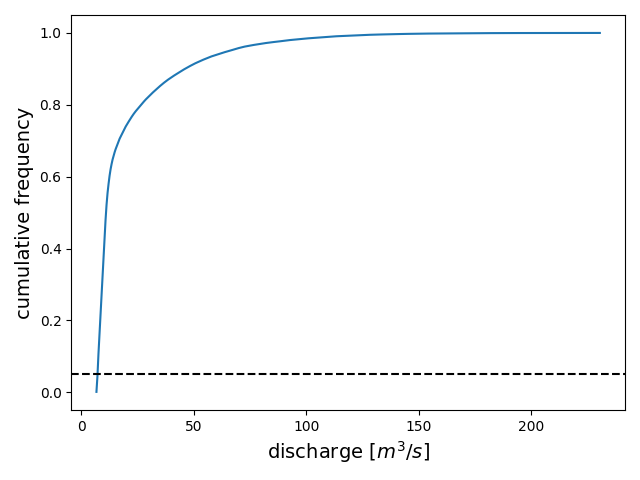

In [5]:
%matplotlib notebook

fig, ax = plt.subplots()

ax.plot(bins, freq)
ax.axhline(0.05, c='k', ls='--')

ax.set_xlabel(r'discharge $[m^3 / s]$', fontsize=14)
ax.set_ylabel(r'cumulative frequency', fontsize=14)

plt.tight_layout()

from the above plot, we read the minimum flow (discharge that is equalled or exceeded 95% of the time):

In [6]:
Q347 = 7.30 # [m^3 / s]

#### Volume rating curve (DELIVERABLE 7)
We compute the area and volume rating curves from the available data.

In [7]:
# load area rating curve
data = np.loadtxt('area_rating_curve.txt')
l = data[:, 0]
area = data[:, 1]

f_area = interp1d(l, area)
volume = [quad(f_area, 0, _l)[0] for _l in l] 
f_volume = interp1d(l, volume)
f_level = interp1d(volume, l)

<ipython-input-7-2933ff4a9f5d>:7: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  volume = [quad(f_area, 0, _l)[0] for _l in l]
<ipython-input-7-2933ff4a9f5d>:7: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  volume = [quad(f_area, 0, _l)[0] for _l in l]


<IPython.core.display.Javascript object>


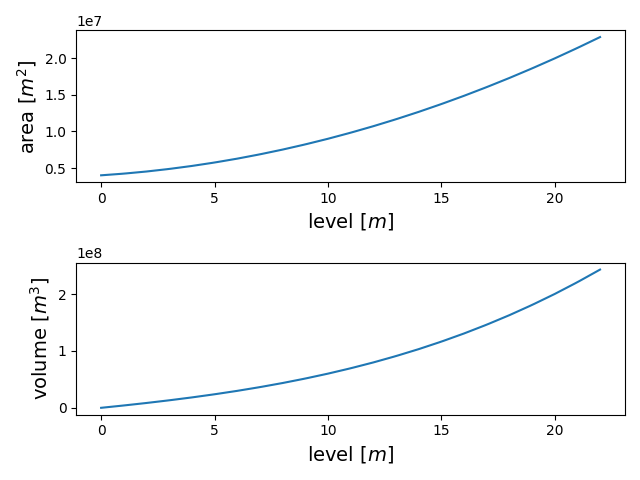

In [8]:
%matplotlib notebook

x = np.linspace(l.min(), l.max(), 100)
V = f_volume(x)
A = f_area(x)

fig, ax = plt.subplots(2)

ax[0].plot(x, A)
ax[1].plot(x, V)

ax[0].set_xlabel(r'level $[m]$', fontsize=14)
ax[0].set_ylabel(r'area $[m^2]$', fontsize=14)

ax[1].set_xlabel(r'level $[m]$', fontsize=14)
ax[1].set_ylabel(r'volume $[m^3]$', fontsize=14)

plt.tight_layout()

#### turbine functioning

The power plant produce a power $P = \eta \: \rho \: g \: h_T \: Q_{HU}$ where $h_T = l + dz - h_{loss}$ and $h_{loss} = \frac{1}{2} \frac{u^2}{2g} + \frac{u^2}{2g} + \frac{L_p}{D} f \frac{u^2}{2g}$ is the hydraulic head loss due to inlet, outlet and pipe friction. The physical parameters (the water density $\rho$, the gravitational acceleration $g$) as well as the system parameters (the turbine efficiency $\eta$, the pipe dimaeter $D$ and length $L_p$ and the discharge $Q_{HU}$) are constant set at the top of the notebook. The friction coefficient $f$ is obtained by solving the Coolebrock equation grafically as below: 

<IPython.core.display.Javascript object>


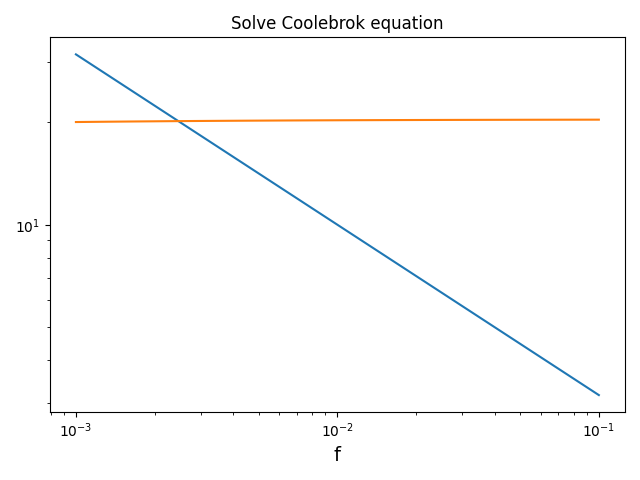

In [9]:
%matplotlib notebook

# first the water velocity in the pipe is found from the discharge and diameter
u = QT / (np.pi * (D / 2)**2) # [m / s]
nu = 1e-6 # [m^2 / s]
Re = u * D / nu

fig, ax = plt.subplots()

f = np.logspace(-3, -1)
y1 = f**-0.5
y2 = -2 * np.log((1e-3 * ks) / D / 3.7 + 2.51 / Re / f**.5)

ax.plot(f, y1)
ax.plot(f, y2)

ax.set_xlabel('f', fontsize=14)
ax.set(xscale='log', yscale='log')
plt.title('Solve Coolebrok equation')
plt.tight_layout()

from which we get the friction coefficient:

In [11]:
f = 0.0024

and the total head loss:

In [12]:
hdrop = (0.5 + 1 + f * Lp / D) * u**2 / (2 * g) # [m]
print(hdrop)

1.0183136764916159


#### reservoir routing 

In [21]:
def reservoir_routing(Q, ET, P, l0, lmax, lmin=9, dt=3600, imax=None, hdrop=1.018):
    """
    Implement the reservoir routing, namely the time evolution of water level following input discharge (Q),
    evapotranspiration (ET) and precipitation (P) timeseries. Parameters for the power plant system, the gate 
    opening, the downstream discharge constraints, the city supply and the crop field irrigation are set at the
    top of the notebook.
    
    Parameters
    ----------
    Q: hourly timeseries of input discharge [m^3 / s]
    ET: hourly timeseries of evapotranspiration [m^3 / s]
    P: hourly timeseries of precipitation [m^3 / s]
    l0: initial water level [m]
    lmax: maximal water level for hydroelectric use (between 9 and 19) [m]
    lmin: minimal water level for for hydroelectric use (default is 9) [m]
    dt: timestep (default is 3600) [s]
    imax: index cutoff for the timeseries (default is None)
    hdrop: friction head loss (default is 1.018) [m]
    
    Returns
    -------
    dictionary with the timeseries of volume ([m^3]), level ([m]), downstream discharge ([m^3 / s]), 
    discharge toward the city and fields ([m^3 / s]) and the generated power ([W]).
    """
    
    # convert maximum level to volume
    Vmax = float(f_volume(lmax))

    # initiate storing dictionary
    data = {
        "volume": [],
        "level": [],
        "Qout": [],
        "QSUP": [],
        "power": [],
    }
    
    # initial conditions
    l = l0
    V = float(f_volume(l))
    
    # iterate over the timeseries
    p1, p2 = False, False
    year = 0
    for i in range(len(Q)):
        
        # count the years
        if i % (24 * 365) == 0:
            #print(year)
            year += 1

        # check water level at midnight
        if i % 24 == 0:
            if l >= lmin:
                p1 = True
            else:
                p1 = False
        
        # check if within running hours (8 to 21)
        if i % 24 == 8:
            p2 = True
        if i % 24 == 21:
            p2 = False
            
        # set discharge to power plant
        if p1 and p2:
            QHU = QT
        else:
            QHU = 0.
        
        # compute generated power
        hT = l + dz - hdrop 
        power = eta * rho * g * hT * QHU # [W]
        
        # crops supply
        QI = (ET[i] - etaP * P[i]) / etacrop * (1e6 * Acrop) # [m ^3 / s]

        # gate oppening 
        Qg = max(Q347, min((V + (Q[i] - QHU - QI - Qcity) * dt - Vmax) / dt, Qlim))
        A = Qg / (Cqsl * (2 * g * l)**.5)

        # output discharge
        if l <= p:
            Qout = Qg
        if l > p:
            Qout = Qg + Cqsp * Lspill * (2 * g * (l - p)**3)**.5

        # update water level
        V += (Q[i] - Qout - QHU - QI - Qcity) * dt
        if V <= 0:
            print("ERROR: empty reservoir")
            break
        l = float(f_level(V))
        
        # store data
        data["volume"].append(V)
        data["level"].append(l)
        data["Qout"].append(Qout)
        data["QSUP"].append(QI + Qcity)
        data["power"].append(power)
        
        # stop if imax is reached
        if imax is not None and i == imax:
            break
            
    data["volume"] = np.array(data["volume"])
    data["level"] = np.array(data["level"])
    data["Qout"] = np.array(data["Qout"])
    data["QSUP"] = np.array(data["QSUP"])
    data["power"] = np.array(data["power"])
    data["t"] = np.arange(len(data["volume"])) / (24 * 365)    
        
    return data

def get_peak_discharges(t, l, Q):
    """
    Count the flooding events and find the maximal downstream discharge for each event. 
    
    Parameters
    ----------
    t: timeseries of times [year]
    l: timeseries of water level [m]
    Q: timeseries of downstream discharges [m^3 / s]
    
    Returns
    -------
    tpeaks: (array) times of peak flood events
    Qpeaks: (array) discharges of peak flood events
    """
    
    # check for floods
    flood = l > p
    
    Qpeaks = list()
    tpeaks = list()
    Qpeak = 0
    f = flood[0]
    for i in range(len(l)):
        
        # look for the peak of the flood event
        if flood[i] and Q[i] > Qpeak:
            Qpeak = Q[i]
            tpeak = t[i]
            f = True
        
        # look for last timepoint of the flood event
        if (not flood[i]) and f:
            f = False
            Qpeaks.append(Qpeak)
            tpeaks.append(tpeak)
            Qpeak = 0
            
    return np.array(tpeaks), np.array(Qpeaks)

Simulation of the reservoir system over the generated 100 years for a maximum level for hydroelectric use of 15 m (**DELIVERABLE 9**):

In [69]:
lmax = 19
l0 = 12

nyear = 100
hour_per_year = 24 * 365
imax = nyear * hour_per_year

data = reservoir_routing(Q, ET, P, l0, lmax, imax=imax)
tpeaks, Qpeaks = get_peak_discharges(data['t'], data['level'], data['Qout'])
I = get_income(Qpeaks, data['power'])

<IPython.core.display.Javascript object>


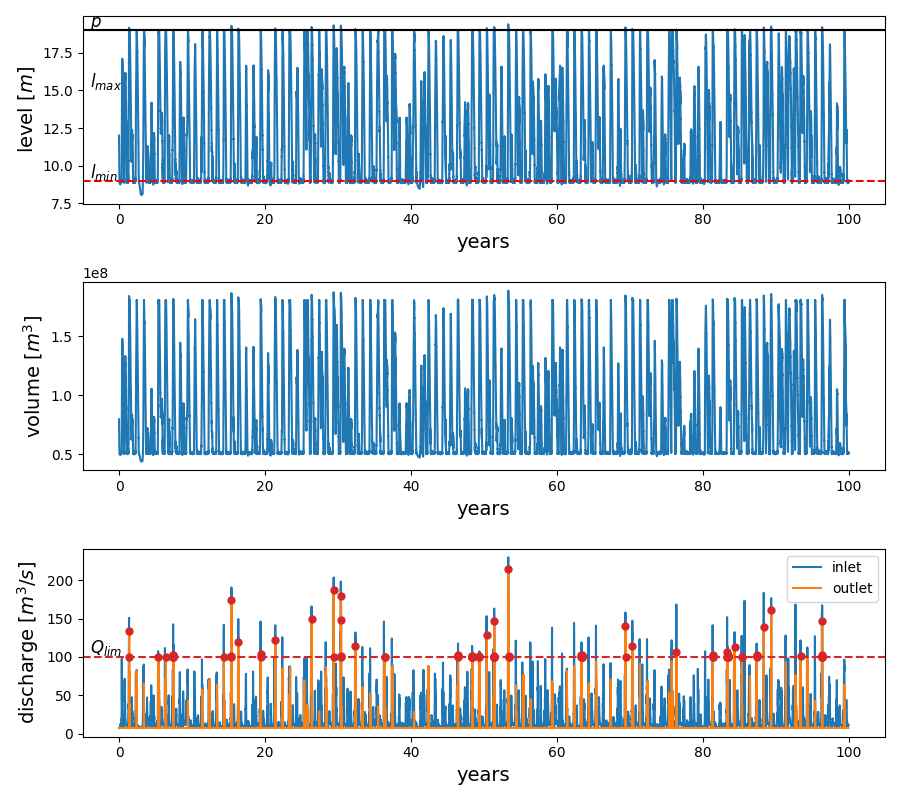

In [70]:
%matplotlib notebook

fig, ax = plt.subplots(3, figsize=(9, 8))

ax[0].plot(data["t"], data['level'])
ax[0].axhline(9, c='r', ls='--')
ax[0].axhline(lmax, c='r', ls='-')
ax[0].axhline(p, c='k')
ax[0].set_xlabel(r'years', fontsize=14)
ax[0].set_ylabel(r'level $[m]$', fontsize=14)
ax[0].text(-4, 9.2, r'$l_{min}$', fontsize=12)
ax[0].text(-4, 15.2, r'$l_{max}$', fontsize=12)
ax[0].text(-4, 19.2, r'$p$', fontsize=12)


ax[1].plot(data["t"], data['volume'])
ax[1].set_xlabel(r'years', fontsize=14)
ax[1].set_ylabel(r'volume $[m^3]$', fontsize=14)

ax[2].plot(data["t"], Q[:imax+1], label=r'inlet')
ax[2].plot(data["t"], data['Qout'], label=r'outlet')
ax[2].axhline(Qlim, c='C3', ls='--')
ax[2].plot(tpeaks, Qpeaks, c='C3', ls='none', marker='o', ms=5)
ax[2].set_xlabel(r'years', fontsize=14)
ax[2].set_ylabel(r'discharge $[m^3 / s]$', fontsize=14)
ax[2].text(-4, 105, r'$Q_{lim}$', fontsize=12)
ax[2].legend()

plt.tight_layout()

#### Scan of the maximal water level for hydroelectric use

Simulation of the reservoir system over the generated 100 years for different values of the maximal water level for hydroelectric use (between 9 m and 19 m). The outputs are stored in the file *scan.pkl*. The flooding probability and the mean annual energy production are then computed for each value of maximal water level. The flooding probability is simply estimated as the fraction of flood timesteps over the total number of timesteps. You can skip the next cell as it takes quite a while to run (~30 minutes) and directly load its output from the next cell.

In [40]:
l0 = 12

hour_per_year = 24 * 365
nyear = 100

lmaxs = np.arange(9, 19, .2)
datas = list()
for lmax in lmaxs:
    data = reservoir_routing(Q, ET, P, l0, lmax, imax=nyear * hour_per_year)
    datas.append(data)
    
with open("scan.pkl", "wb") as f:
    pickle.dump(datas, f)

In [50]:
with open("scan.pkl", "rb") as f:
    datas = pickle.load(f)
    
flood_probs = list()
mean_Eprods = list()
mean_income = list()

for data in datas:
    
    tpeaks, Qpeaks = get_peak_discharges(data['t'], data['level'], data['Qout'])
    I = get_income(Qpeaks, data['power'])
    annual_Eprod = np.array([sum(data['power'][i * hour_per_year:(i+1) * hour_per_year]) * 1e-9 for i in range(nyear)])
    
    mean_Eprods.append(annual_Eprod.mean())
    flood_probs.append((np.array(data['Qout']) > Qlim).mean())
    mean_income.append(I / nyear)

We plot the average annual energy production in GWh and the probability that $Q_{out}$
exceeds $Q_{lim}$ for different values of the maximum level for hydroelectrical use (**DELIVRABLE 10**):

<IPython.core.display.Javascript object>


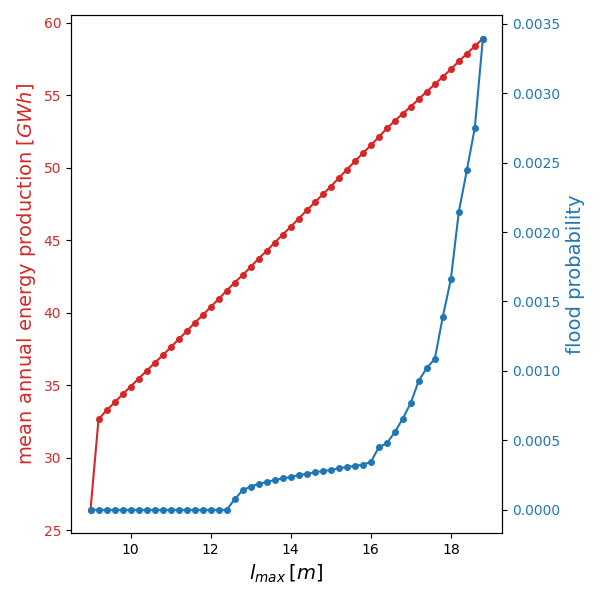

In [52]:
%matplotlib notebook

fig, ax1 = plt.subplots(figsize=(6, 6))

color = 'tab:red'
ax1.set_xlabel(r"$l_{max} \: [m]$", fontsize=14)
ax1.set_ylabel(r"mean annual energy production $[GWh]$", fontsize=14, color=color)
ax1.plot(lmaxs, mean_Eprods, c=color, marker='o', ms=4)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('flood probability', fontsize=14, color=color)
ax2.plot(lmaxs, flood_probs, c=color, marker='o', ms=4)
ax2.tick_params(axis='y', labelcolor=color)

plt.tight_layout()

We plot the Pareto front of the average annual energy production vs the probability of flooding computed for different values of maximal water level for hydroelectric use (**DELIVERABLE 11**):

<IPython.core.display.Javascript object>


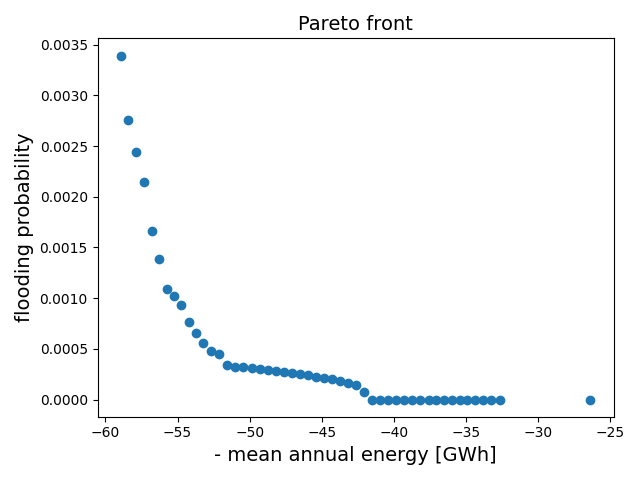

In [55]:
%matplotlib notebook

fig, ax = plt.subplots()

ax.plot(-np.array(mean_Eprods), np.array(flood_probs), ls='none', marker='o')
ax.set_xlabel(r'- mean annual energy [GWh]', fontsize=14)
ax.set_ylabel(r'flooding probability', fontsize=14)
ax.set_title('Pareto front', fontsize=14)

plt.tight_layout()

When designing the reservoir (choosing the value of maximum level for hydroelectrical use) one need to set a tradeoff between two competing objectives: 
* the production of energy
* the preservation of river ecological services and flooding prevention

Increasing the maximum level favors the first objective while it is detrimental for the second. Because the two objective cannot be quatified with the same metric, an absolute obtimal solution is elusive. The Pareto front represent continuously the tradeoff between the two objectives. In general, more than one free parameter (here the maximal water level) can be tuned in the design (one could change the daily patterns of energy production, the discharge supplied to the power plant,...), so that the Pareto front corresponds to the manifold were improving one objective is only possible by reducing the other one. Hence the Pareto front analysis allows first to find the manifold of optimal solutions (if there is more than one free parameter) and second to have a graphical representation of the competition between the two objectives. For instance, in the above plot, we see that the flooding probability reaches zero for annual energy productions smaller than 42 GWh, hence targeting smaller energy production would not benefit more to the second objective. 

(**DELIVERABLE 12**)

#### Power plant income
One can also try to quantify both objective with a monetary metric even though it is difficult to justify how to quatify the monetary value of ecological services. Here we simply assume that the flooding cost only depends ont the  material damages and is an increasing function of the water depth downstream. There is no cost as long as the river remains within its bed. For a water stage $y = 0.1 \sqrt{Q_{out}}$, there is no cost if $y < y_{lim} = 0.1 \sqrt{Q_{lim}} + y_{bank}$. If however, $y > y_{lim}$ the flooding cost is $(1 + (y - y_{lim}))^{2.25}$ MCHF. 

The hydroelectric revenue is 75 CHF per MWh. 

We study the power plant income (damage cost - revenue) for different values of maximal water level. See plot below (**DELIVERABLE 13**).

In [85]:
with open("scan.pkl", "rb") as f:
    datas = pickle.load(f)

ybank = 0.5

exp = list()
rev = list()
for data in datas:
    
    tpeaks, Qpeaks = get_peak_discharges(data['t'], data['level'], data['Qout'])
    
    z = 0.1 * Qpeaks**.5 - (0.1 * Qlim**.5 + ybank)
    exp.append((1e6 * (1 + z)**2.25)[z > 0].sum() / nyear)
    rev.append(data['power'].sum() * 75e-6 / nyear)

exp = np.array(exp)
rev = np.array(rev)

<IPython.core.display.Javascript object>


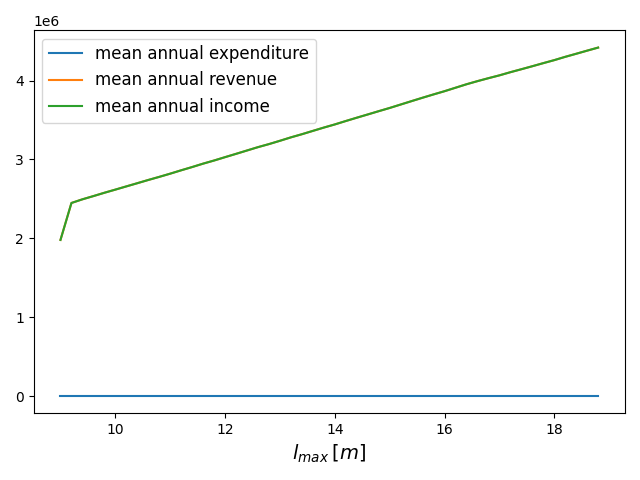

In [86]:
%matplotlib notebook

fig, ax = plt.subplots()

ax.plot(lmaxs, exp, label=r'mean annual expenditure')
ax.plot(lmaxs, rev, label=r'mean annual revenue')
ax.plot(lmaxs, rev - exp, label=r'mean annual income')

ax.set_xlabel(r"$l_{max} \: [m]$", fontsize=14)

plt.legend(fontsize=12)

plt.tight_layout()

For $y_{bank} = 0.5 m$ as suggested in the exercice description, no flood event excceds the river banks for any maximal water level. Hence the income is maximazed for the maximal maximal water level, namely $l_{max} = 19 m$, and is worth 4.40 MCHF / year.
If however $y_{bank} = 0 m$, the income function flattens for values of $l_{max}$ larger than 17 m, with a maximum at $l_{max} = 18.6 m$ and an income of 4.14 MCH.
(**DELIVERABLE 14**)